# Homework and bake-off: Word similarity

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Dataset readers](#Dataset-readers)
1. [Dataset comparisons](#Dataset-comparisons)
  1. [Vocab overlap](#Vocab-overlap)
  1. [Pair overlap and score correlations](#Pair-overlap-and-score-correlations)
1. [Evaluation](#Evaluation)
  1. [Dataset evaluation](#Dataset-evaluation)
  1. [Dataset error analysis](#Dataset-error-analysis)
  1. [Full evaluation](#Full-evaluation)
1. [Homework questions](#Homework-questions)
  1. [PPMI as a baseline [0.5 points]](#PPMI-as-a-baseline-[0.5-points])
  1. [Gigaword with LSA at a few dimensions [0.5 points]](#Gigaword-with-LSA-at-a-few-dimensions-[0.5-points])
  1. [Gigaword with GloVe for a small number of iterations [0.5 points]](#Gigaword-with-GloVe-for-a-small-number-of-iterations-[0.5-points])
  1. [Dice coefficient [0.5 points]](#Dice-coefficient-[0.5-points])
  1. [t-test reweighting [2 points]](#t-test-reweighting-[2-points])
  1. [Enriching a VSM with subword information [2 points]](#Enriching-a-VSM-with-subword-information-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])

## Overview

Word similarity datasets have long been used to evaluate distributed representations. This notebook provides basic code for conducting such analyses with a number of datasets:

| Dataset | Pairs | Task-type | Current best Spearman $\rho$ | Best $\rho$ paper |   |
|---------|-------|-----------|------------------------------|-------------------|---|
| [WordSim-353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/) | 353 | Relatedness | 82.8 | [Speer et al. 2017](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14972) |
| [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) | 771 | Relatedness | 81.0 | [Speer et al. 2017](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14972) |
| [The MEN Test Collection](http://clic.cimec.unitn.it/~elia.bruni/MEN) | 3,000 | Relatedness | 86.6 | [Speer et al. 2017](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14972)  | 
| [SimVerb-3500-dev](http://people.ds.cam.ac.uk/dsg40/simverb.html) | 500 | Similarity | 61.1 | [Mrki&scaron;&cacute; et al. 2016](https://arxiv.org/pdf/1603.00892.pdf) |
| [SimVerb-3500-test](http://people.ds.cam.ac.uk/dsg40/simverb.html) | 3,000 | Similarity | 62.4 | [Mrki&scaron;&cacute; et al. 2016](https://arxiv.org/pdf/1603.00892.pdf) |

Each of the similarity datasets contains word pairs with an associated human-annotated similarity score. (We convert these to distances to align intuitively with our distance measure functions.) The evaluation code measures the distance between the word pairs in your chosen VSM (which should be a `pd.DataFrame`).

The evaluation metric for each dataset is the [Spearman correlation coefficient $\rho$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the annotated scores and your distances, as is standard in the literature. We also macro-average these correlations across the datasets for an overall summary. (In using the macro-average, we are saying that we care about all the datasets equally, even though they vary in size.)

This homework ([questions at the bottom of this notebook](#Homework-questions)) asks you to write code that uses the count matrices in `data/vsmdata` to create and evaluate some baseline models as well as an original model $M$ that you design. This accounts for 9 of the 10 points for this assignment.

For the associated bake-off, we will distribute two new word similarity or relatedness datasets and associated reader code, and you will evaluate $M$ (no additional training or tuning allowed!) on those new datasets. Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points.

## Set-up

In [2]:
from collections import defaultdict
import csv
import itertools
import numpy as np
import os
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns

import vsm

In [3]:
VSM_HOME = os.path.join('data', 'vsmdata')

WORDSIM_HOME = os.path.join('data', 'wordsim')

In [61]:
def load_counts(name):
    return pd.read_csv(
        os.path.join(VSM_HOME, f"{name}.csv.gz"),
        index_col=0
    )

giga20_flat = load_counts('giga_window20-flat')
imdb20_flat = load_counts('imdb_window20-flat')
giga5_scaled = load_counts('giga_window5-scaled')
imdb5_scaled = load_counts('imdb_window5-scaled')

## Dataset readers

In [4]:
def wordsim_dataset_reader(
        src_filename, 
        header=False, 
        delimiter=',', 
        score_col_index=2):
    """Basic reader that works for all similarity datasets. They are 
    all tabular-style releases where the first two columns give the 
    word and a later column (`score_col_index`) gives the score.

    Parameters
    ----------
    src_filename : str
        Full path to the source file.
    header : bool
        Whether `src_filename` has a header. Default: False
    delimiter : str
        Field delimiter in `src_filename`. Default: ','
    score_col_index : int
        Column containing the similarity scores Default: 2

    Yields
    ------
    (str, str, float)
       (w1, w2, score) where `score` is the negative of the similarity
       score in the file so that we are intuitively aligned with our
       distance-based code. To align with our VSMs, all the words are 
       downcased.

    """
    with open(src_filename) as f:
        reader = csv.reader(f, delimiter=delimiter)
        if header:
            next(reader)
        for row in reader:
            w1 = row[0].strip().lower()
            w2 = row[1].strip().lower()
            score = row[score_col_index]
            # Negative of scores to align intuitively with distance functions:
            score = -float(score)
            yield (w1, w2, score)

def wordsim353_reader():
    """WordSim-353: http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'wordsim353', 'combined.csv')
    return wordsim_dataset_reader(
        src_filename, header=True)

def mturk771_reader():
    """MTURK-771: http://www2.mta.ac.il/~gideon/mturk771.html"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'MTURK-771.csv')
    return wordsim_dataset_reader(
        src_filename, header=False)

def simverb3500dev_reader():
    """SimVerb-3500: http://people.ds.cam.ac.uk/dsg40/simverb.html"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'SimVerb-3500', 'SimVerb-500-dev.txt')
    return wordsim_dataset_reader(
        src_filename, delimiter="\t", header=True, score_col_index=3)

def simverb3500test_reader():
    """SimVerb-3500: http://people.ds.cam.ac.uk/dsg40/simverb.html"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'SimVerb-3500', 'SimVerb-3000-test.txt')
    return wordsim_dataset_reader(
        src_filename, delimiter="\t", header=True, score_col_index=3)

def men_reader():
    """MEN: http://clic.cimec.unitn.it/~elia.bruni/MEN"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'MEN', 'MEN_dataset_natural_form_full')
    return wordsim_dataset_reader(
        src_filename, header=False, delimiter=' ') 

This collection of readers will be useful for flexible evaluations:

In [5]:
READERS = (wordsim353_reader, mturk771_reader, simverb3500dev_reader, 
           simverb3500test_reader, men_reader)

## Dataset comparisons

This section does some basic analysis of the datasets. The goal is to obtain a deeper understanding of what problem we're solving – what strengths and weaknesses the datasets have and how they relate to each other. For a full-fledged project, we would want to continue work like this and report on it in the paper, to provide context for the results.

In [6]:
def get_reader_name(reader):
    """Return a cleaned-up name for the similarity dataset 
    iterator `reader`
    """
    return reader.__name__.replace("_reader", "")

### Vocab overlap

How many vocabulary items are shared across the datasets?

In [7]:
def get_reader_vocab(reader):
    """Return the set of words (str) in `reader`."""
    vocab = set()
    for w1, w2, _ in reader():
        vocab.add(w1)
        vocab.add(w2)
    return vocab

In [8]:
def get_reader_vocab_overlap(readers=READERS):
    """Get data on the vocab-level relationships between pairs of 
    readers. Returns a a pd.DataFrame containing this information.
    """
    data = []
    for r1, r2 in itertools.product(readers, repeat=2):       
        v1 = get_reader_vocab(r1)
        v2 = get_reader_vocab(r2)
        d = {
            'd1': get_reader_name(r1),
            'd2': get_reader_name(r2),
            'overlap': len(v1 & v2), 
            'union': len(v1 | v2),
            'd1_size': len(v1),
            'd2_size': len(v2)}
        data.append(d)
    return pd.DataFrame(data)

In [9]:
vocab_overlap = get_reader_vocab_overlap()

In [10]:
def vocab_overlap_crosstab(vocab_overlap):
    """Return an intuitively formatted `pd.DataFrame` giving 
    vocab-overlap counts for all the datasets represented in 
    `vocab_overlap`, the output of `get_reader_vocab_overlap`.
    """        
    xtab = pd.crosstab(
        vocab_overlap['d1'], 
        vocab_overlap['d2'], 
        values=vocab_overlap['overlap'], 
        aggfunc=np.mean)
    # Blank out the upper left to reduce visual clutter:
    for i in range(0, xtab.shape[0]):
        for j in range(i+1, xtab.shape[1]):
            xtab.iloc[i, j] = ''        
    return xtab        

In [11]:
vocab_overlap_crosstab(vocab_overlap)

d2,men,mturk771,simverb3500dev,simverb3500test,wordsim353
d1,,,,,
men,751,,,,
mturk771,230,1113,,,
simverb3500dev,23,67,536,,
simverb3500test,30,94,532,823,
wordsim353,86,158,13,17,437


This looks reasonable. By design, the SimVerb dev and test sets have a lot of overlap. The other overlap numbers are pretty small, even adjusting for dataset size.

In [12]:
df = pd.DataFrame(wordsim353_reader(), columns=['w1', 'w2', 'dist']).sort_values('dist')

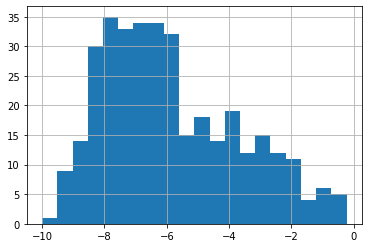

In [13]:
_ = df.dist.hist(bins=20)

In [14]:
df[(df.w1=='money')]

,w1,w2,dist
31,money,cash,-9.15
97,money,cash,-9.08
98,money,currency,-9.04
102,money,bank,-8.50
96,money,dollar,-8.42
99,money,wealth,-8.27
103,money,deposit,-7.73
100,money,property,-7.57
101,money,possession,-7.29
104,money,withdrawal,-6.88


### Pair overlap and score correlations

How many word pairs are shared across datasets and, for shared pairs, what is the correlation between their scores? That is, do the datasets agree?

In [15]:
def get_reader_pairs(reader):
    """Return the set of alphabetically-sorted word (str) tuples 
    in `reader`
    """
    return {tuple(sorted([w1, w2])): score for w1, w2, score in reader()}

In [16]:
def get_reader_pair_overlap(readers=READERS):
    """Return a `pd.DataFrame` giving the number of overlapping 
    word-pairs in pairs of readers, along with the Spearman 
    correlations.
    """    
    data = []
    for r1, r2 in itertools.product(READERS, repeat=2):
        if r1.__name__ != r2.__name__:
            d1 = get_reader_pairs(r1)
            d2 = get_reader_pairs(r2)
            overlap = []
            for p, s in d1.items():
                if p in d2:
                    overlap.append([s, d2[p]])
            if overlap:
                s1, s2 = zip(*overlap)
                rho = spearmanr(s1, s2)[0]
            else:
                rho = None        
            d = {
                'd1': get_reader_name(r1),
                'd2': get_reader_name(r2), 
                'pair_overlap': len(overlap),
                'rho': rho}
            data.append(d)
    df = pd.DataFrame(data)
    df = df.sort_values('pair_overlap', ascending=False)
    # Return only every other row to avoid repeats:
    return df[::2].reset_index(drop=True)

In [17]:
get_reader_pair_overlap()

,d1,d2,pair_overlap,rho
0,men,mturk771,11,0.592191
1,wordsim353,men,5,0.700000
2,simverb3500test,mturk771,4,0.400000
3,men,simverb3500test,2,1.000000
4,simverb3500test,simverb3500dev,1,NaN
5,wordsim353,simverb3500dev,0,NaN
6,simverb3500test,wordsim353,0,NaN
7,simverb3500dev,wordsim353,0,NaN
8,mturk771,wordsim353,0,NaN
9,men,simverb3500dev,0,NaN


This looks reasonable: none of the datasets have a lot of overlapping pairs, so we don't have to worry too much about places where they give conflicting scores.

## Evaluation

This section builds up the evaluation code that you'll use for the homework and bake-off. For illustrations, I'll read in a VSM created from `data/vsmdata/giga_window5-scaled.csv.gz`:

### Dataset evaluation

In [19]:
def word_similarity_evaluation(reader, df, distfunc=vsm.cosine):
    """Word-similarity evalution framework.
    
    Parameters
    ----------
    reader : iterator
        A reader for a word-similarity dataset. Just has to yield
        tuples (word1, word2, score).    
    df : pd.DataFrame
        The VSM being evaluated.        
    distfunc : function mapping vector pairs to floats.
        The measure of distance between vectors. Can also be 
        `vsm.euclidean`, `vsm.matching`, `vsm.jaccard`, as well as 
        any other float-valued function on pairs of vectors.    
        
    Raises
    ------
    ValueError
        If `df.index` is not a subset of the words in `reader`.
    
    Returns
    -------
    float, data
        `float` is the Spearman rank correlation coefficient between 
        the dataset scores and the similarity values obtained from 
        `df` using  `distfunc`. This evaluation is sensitive only to 
        rankings, not to absolute values.  `data` is a `pd.DataFrame` 
        with columns['word1', 'word2', 'score', 'distance'].
        
    """
    data = []
    for w1, w2, score in reader():
        d = {'word1': w1, 'word2': w2, 'score': score}
        for w in [w1, w2]:
            if w not in df.index:
                raise ValueError(
                    "Word '{}' is in the similarity dataset {} but not in the "
                    "DataFrame, making this evaluation ill-defined. Please "
                    "switch to a DataFrame with an appropriate vocabulary.".
                    format(w, get_reader_name(reader))) 
        d['distance'] = distfunc(df.loc[w1], df.loc[w2])
        data.append(d)
    data = pd.DataFrame(data)
    rho, pvalue = spearmanr(data['score'].values, data['distance'].values)
    return rho, data

In [20]:
rho, eval_df = word_similarity_evaluation(men_reader, giga5)

In [22]:
rho

0.40375964105441753

In [23]:
eval_df.head()

,distance,score,word1,word2
0,0.956828,-50.0,sun,sunlight
1,0.979143,-50.0,automobile,car
2,0.970105,-49.0,river,water
3,0.980475,-49.0,stairs,staircase
4,0.963624,-49.0,morning,sunrise


### Dataset error analysis

For error analysis, we can look at the words with the largest delta between the gold score and the distance value in our VSM. We do these comparisons based on ranks, just as with our primary metric (Spearman $\rho$), and we normalize both rankings so that they have a comparable number of levels.

In [24]:
def word_similarity_error_analysis(eval_df, norm_by_max=False):    
    eval_df['distance_rank'] = _normalized_ranking(eval_df['distance'], norm_by_max)
    eval_df['score_rank'] = _normalized_ranking(eval_df['score'], norm_by_max)
    eval_df['error'] =  abs(eval_df['distance_rank'] - eval_df['score_rank'])
    return eval_df.sort_values('error')
    
    
def _normalized_ranking(series, use_max=False):
    ranks = series.rank(method='dense')
    norm = ranks.max() if use_max else ranks.sum()
    return ranks / norm

Best predictions:

In [25]:
word_similarity_error_analysis(eval_df).head()

,distance,score,word1,word2,distance_rank,score_rank,error
1041,0.975007,-32.0,hummingbird,pelican,0.000243,0.000244,2.434543e-07
2315,0.980834,-13.0,lily,pigs,0.000488,0.000487,4.016842e-07
2951,0.983473,-4.0,bucket,girls,0.000602,0.000603,4.151568e-07
150,0.968690,-43.0,night,sunset,0.000102,0.000103,6.520315e-07
2062,0.979721,-17.0,oak,petals,0.000435,0.000436,7.162632e-07


Worst predictions:

In [26]:
word_similarity_error_analysis(eval_df).tail()

,distance,score,word1,word2,distance_rank,score_rank,error
67,0.984622,-45.0,branch,twigs,0.000630,0.000077,0.000553
190,0.987704,-43.0,birds,stork,0.000657,0.000103,0.000554
185,0.990993,-43.0,bloom,tulip,0.000663,0.000103,0.000561
167,0.991760,-43.0,bloom,blossom,0.000664,0.000103,0.000561
198,0.992406,-43.0,bloom,rose,0.000664,0.000103,0.000561


### Full evaluation

A full evaluation is just a loop over all the readers on which one want to evaluate, with a macro-average at the end:

In [46]:
def full_word_similarity_evaluation(df, readers=READERS):
    """Evaluate a VSM against all datasets in `readers`.
    
    Parameters
    ----------
    df : pd.DataFrame
    readers : tuple 
        The similarity dataset readers on which to evaluate.
    
    Returns
    -------
    pd.Series
        Mapping dataset names to Spearman r values.
        
    """        
    scores = {}     
    for reader in readers:
        score, data_df = word_similarity_evaluation(reader, df)
        scores[get_reader_name(reader)] = score
    series = pd.Series(scores, name='Spearman r')
    series['Macro-average'] = series.mean()
    series['Macro-std'] = series.std()
    return series

## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### PPMI as a baseline [0.5 points]

The insight behind PPMI is a recurring theme in word representation learning, so it is a natural baseline for our task. For this question, submit code to do the following:

1. Read the two count matrices created with a window of 20 and a flat scaling function into `pd.DataFrame`s, as is done in the VSM notebooks. The files are `data/vsmdata/giga_window20-flat.csv.gz` and `data/vsmdata/imdb_window20-flat.csv.gz`, and the VSM notebooks provide examples of the needed code.

1. Reweight these count matries with PPMI.

1. Evaluate these reweighted matrices using `full_word_similarity_evaluation`.

The goal of this question is to help you get more familiar with the code in `vsm` and the function `full_word_similarity_evaluation`.

In [63]:
full_word_similarity_evaluation(giga20_flat)

wordsim353         0.176563
mturk771           0.196009
simverb3500dev    -0.015675
simverb3500test    0.046552
men                0.215239
Macro-average      0.123738
Macro-std          0.091411
Name: Spearman r, dtype: float64

In [64]:
full_word_similarity_evaluation(imdb20_flat)

wordsim353         0.095928
mturk771           0.126689
simverb3500dev    -0.029194
simverb3500test    0.018559
men                0.151616
Macro-average      0.072720
Macro-std          0.067817
Name: Spearman r, dtype: float64

In [66]:
full_word_similarity_evaluation(giga5_scaled)

wordsim353         0.327831
mturk771           0.143146
simverb3500dev    -0.068038
simverb3500test   -0.066348
men                0.403760
Macro-average      0.148070
Macro-std          0.195137
Name: Spearman r, dtype: float64

In [67]:
full_word_similarity_evaluation(imdb5_scaled)

wordsim353         0.310778
mturk771           0.140944
simverb3500dev    -0.027357
simverb3500test   -0.026962
men                0.401341
Macro-average      0.159749
Macro-std          0.174011
Name: Spearman r, dtype: float64

In [68]:
giga20_flat_pmi = vsm.pmi(giga20_flat)
imdb20_flat_pmi = vsm.pmi(imdb20_flat)
giga5_scaled_pmi = vsm.pmi(giga5_scaled)
imdb5_scaled_pmi = vsm.pmi(imdb5_scaled)

In [69]:
full_word_similarity_evaluation(giga5_scaled_pmi)

wordsim353         0.604212
mturk771           0.587155
simverb3500dev     0.316475
simverb3500test    0.250925
men                0.696400
Macro-average      0.491033
Macro-std          0.174555
Name: Spearman r, dtype: float64

In [70]:
full_word_similarity_evaluation(imdb5_scaled_pmi)

wordsim353         0.577190
mturk771           0.562433
simverb3500dev     0.310526
simverb3500test    0.270943
men                0.660408
Macro-average      0.476300
Macro-std          0.155657
Name: Spearman r, dtype: float64

In [71]:
full_word_similarity_evaluation(imdb20_flat_pmi)

wordsim353         0.445679
mturk771           0.453430
simverb3500dev     0.194134
simverb3500test    0.128004
men                0.549878
Macro-average      0.354225
Macro-std          0.163273
Name: Spearman r, dtype: float64

In [72]:
full_word_similarity_evaluation(giga20_flat_pmi)

wordsim353         0.582573
mturk771           0.495228
simverb3500dev     0.232637
simverb3500test    0.158925
men                0.624885
Macro-average      0.418850
Macro-std          0.188322
Name: Spearman r, dtype: float64

In [87]:
methods = [
    ('giga5_scaled', giga5_scaled),
    ('imdb5_scaled', imdb5_scaled),
    ('imdb20_flat', imdb20_flat),
    ('giga20_flat', giga20_flat),
    (, )
]


def get_results_for_multiple_methods(method_name_func_pairs):
    results = [
        full_word_similarity_evaluation(func)
        for _, func in method_name_func_pairs
    ]
    
    names = [name for (name, _) in name_method_pairs]
    
    return pd.DataFrame(results, index=names)

### Gigaword with LSA at a few dimensions [0.5 points]

We might expect PPMI and LSA to form a solid pipeline that combines the strengths of PPMI with those of dimensionality reduction. However, LSA has a hyper-parameter $k$ – the dimensionality of the final representations – that will impact performance. For this problem, submit code to do the following:

1. Apply LSA with $k \in  \{100, 500, 1000\}$ to the PPMI reweighted version of `data/vsmdata/giga_window20-flat.csv.gz` that you created in the previous question.

2. Print out each $k$ and its associated score. (For concise, clear code, you can use `results.loc['Macro-average']` where `results` is a `pd.DataFrame` returned by `full_word_similarity_evaluation`.) We are not especially concerned with the formatting of the strings that you print out; do something that is intuitive for you.

The goal of this question is to help you get a feel for how much LSA alone can contribute to this problem.

In [35]:
##### YOUR CODE HERE
lsa_results = {}
for k in (100, 500, 1000):
    matrix = vsm.lsa(giga20_flat_pmi, k=k)
    macro_average = full_word_similarity_evaluation(matrix).loc['Macro-average']
    print(f'k={k}, macro-average={macro_average:.3f}')

k=100, macro-average=0.419
k=500, macro-average=0.426
k=1000, macro-average=0.424


In [88]:
##### YOUR CODE HERE
lsa_results = {}
for k in (100, 500, 1000):
    matrix = vsm.lsa(giga5_scaled_pmi, k=k)
    macro_average = full_word_similarity_evaluation(matrix).loc['Macro-average']
    print(f'k={k}, macro-average={macro_average:.3f}')

k=100, macro-average=0.484
k=500, macro-average=0.505
k=1000, macro-average=0.501


### Gigaword with GloVe for a small number of iterations [0.5 points]

Ideally, we would run GloVe for a very large number of iterations on a GPU machine to compare it against its close cousin PMI. However, we don't want this homework to cost you a lot of money or monopolize a lot of your available computing resources, so let's instead just probe GloVe a little bit to see if it has promise for our task. For this problem, submit code to do the following:

1. Run GloVe for 10, 100, and 200 iterations on `data/vsmdata/giga_window20-flat.csv.gz`, using the `mittens` implementation of `GloVe`. 
  * For all the other parameters to `mittens.GloVe` besides `max_iter`, use the package's defaults.
  * Because of the way that implementation is designed, these will have to be separate runs, but they should be relatively quick. 
1. Print out each value of `max_iter` and its associated score according to `full_word_similarity_evaluation`. The trend should give you a sense for whether it is worth running GloVe for more iterations.
  * Note: your trained GloVe matrix `X` needs to be wrapped in a `pd.DataFrame` to work with `full_word_similarity_evaluation`. `pd.DataFrame(X, index=giga20.index)` will do the trick.
  * Note: if `glv` is your GloVe model, then running `glv.sess.close()` after each model is trained will silence warnings from TensorFlow about interactive sessions being active.

In [36]:
from mittens import GloVe

##### YOUR CODE HERE
for max_iter in (10, 100, 200):
    glove = GloVe(max_iter=max_iter)
    matrix = glove.fit(giga20_flat)
    glove.sess.close()
    macro_average = full_word_similarity_evaluation(pd.DataFrame(matrix, index=giga20_flat.index))['Macro-average']
    print(f'max_iter={max_iter}, macro_average={macro_average:.3f}')







Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Iteration 10: loss: 22357788.0

max_iter=10, macro_average=0.049


Iteration 100: loss: 2713531.5

max_iter=100, macro_average=0.137


Iteration 200: loss: 1970205.25

max_iter=200, macro_average=0.199


### Dice coefficient [0.5 points]

Implement the Dice coefficient for real-valued vectors, as

$$
\textbf{dice}(u, v) = 
1 - \frac{
  2 \sum_{i=1}^{n}\min(u_{i}, v_{i})
}{
    \sum_{i=1}^{n} u_{i} + v_{i}
}$$
 
You can use `test_dice_implementation` below to check that your implementation is correct.

In [37]:
def test_dice_implementation(func):
    """`func` should be an implementation of `dice` as defined above."""
    X = np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]) 
    assert func(X[0], X[1]).round(5) == 0.80198
    assert func(X[1], X[2]).round(5) == 0.67568


In [38]:
##### YOUR CODE HERE
def dice(u, v):
    numerator = np.min([u, v], axis=0).sum()
    denominator = (u + v).sum()
    
    return 1 - (2 * numerator) / denominator
    
test_dice_implementation(dice)


### t-test reweighting [2 points]



The t-test statistic can be thought of as a reweighting scheme. For a count matrix $X$, row index $i$, and column index $j$:

$$\textbf{ttest}(X, i, j) = 
\frac{
    P(X, i, j) - \big(P(X, i, *)P(X, *, j)\big)
}{
\sqrt{(P(X, i, *)P(X, *, j))}
}$$

where $P(X, i, j)$ is $X_{ij}$ divided by the total values in $X$, $P(X, i, *)$ is the sum of the values in row $i$ of $X$ divided by the total values in $X$, and $P(X, *, j)$ is the sum of the values in column $j$ of $X$ divided by the total values in $X$.

For this problem, implement this reweighting scheme. You can use `test_ttest_implementation` below to check that your implementation is correct. You do not need to use this for any evaluations, though we hope you will be curious enough to do so!

In [39]:
def test_ttest_implementation(func):
    """`func` should be an implementation of t-test reweighting as 
    defined above.
    """
    X = pd.DataFrame(np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]))
    actual = np.array([
        [ 0.33056, -0.07689,  0.04321, -0.10532],
        [-0.07689,  0.03839, -0.10874,  0.07574],
        [ 0.04321, -0.10874,  0.36111, -0.14894],
        [-0.10532,  0.07574, -0.14894,  0.05767]])    
    predicted = func(X)
    assert np.array_equal(predicted.round(5), actual)

In [40]:
##### YOUR CODE HERE
def ttest(X):
    total = X.sum().sum()
    Pij = X / total
    Pi = X.sum(axis=0) / total
    Pj = X.sum(axis=1) / total
    PiPj = np.outer(Pi, Pj)
    
    numerator = Pij - PiPj
    denominator = np.sqrt(PiPj)
    
    return numerator / denominator

test_ttest_implementation(ttest)

### Enriching a VSM with subword information [2 points]

It might be useful to combine character-level information with word-level information. To help you begin asssessing this idea, this question asks you to write a function that modifies an existing VSM so that the representation for each word $w$ is the element-wise sum of $w$'s original word-level representation with all the representations for the n-grams $w$ contains. 

The following starter code should help you structure this and clarify the requirements, and a simple test is included below as well.

You don't need to write a lot of code; the motivation for this question is that the function you write could have practical value.

In [41]:
# my changes
def test_subword_enrichment(func):
    """`func` should be an implementation of subword_enrichment as 
    defined above.
    """
    vocab = ["ABCD", "BCDA", "CDAB", "DABC"]
    df = pd.DataFrame([
        [1, 1, 2, 1],
        [3, 4, 2, 4],
        [0, 0, 1, 0],
        [1, 0, 0, 0]], index=vocab)

    expected = pd.DataFrame([
        [20, 10, 20, 54],
        [24, 10, 24, 50],
        [16,  6, 16, 34],
        [36, 10, 12, 66]], index=vocab)
    
    new_df = func(df, n=2)
    

    assert np.array_equal(expected.columns, new_df.columns), \
        "Columns are not the same"
    assert np.array_equal(expected.index, new_df.index), \
        "Indices are not the same"
    assert np.array_equal(expected.values, new_df.values), \
        "Co-occurrence values aren't the same"    
    
    # # orig, with X_test
# def test_subword_enrichment(func):
#     """`func` should be an implementation of subword_enrichment as 
#     defined above.
#     """
#     vocab = ["ABCD", "BCDA", "CDAB", "DABC"]
#     df = pd.DataFrame([
#         [1, 1, 2, 1],
#         [3, 4, 2, 4],
#         [0, 0, 1, 0],
#         [1, 0, 0, 0]], index=vocab)

#     expected = pd.DataFrame([
#         [20, 10, 20, 54],
#         [24, 10, 24, 50],
#         [16,  6, 16, 34],
#         [36, 10, 12, 66]], index=vocab)
#     new_df = func(df, n=2)
#     assert np.array_equal(X_test.columns, new_df.columns), \
#         "Columns are not the same"
#     assert np.array_equal(X_test.index, new_df.index), \
#         "Indices are not the same"
#     assert np.array_equal(expected.values, new_df.values), \
#         "Co-occurrence values aren't the same"    
    

Note that this fails, but I think there might just be a bug in the test case.

In [42]:
def subword_enrichment(df, n=4):
    
    # 1. Use `vsm.ngram_vsm` to create a character-level 
    # VSM from `df`, using the above parameter `n` to 
    # set the size of the ngrams.
    
    ##### YOUR CODE HERE
    cdf = vsm.ngram_vsm(df, n=n)

        
    # 2. Use `vsm.character_level_rep` to get the representation
    # for every word in `df` according to the character-level
    # VSM you created above.
    
    ##### YOUR CODE HERE
    sub_repr_df = df.index.to_series().apply(lambda word: pd.Series(vsm.character_level_rep(word, cdf, n=n)))

    
    # 3. For each representation created at step 2, add in its
    # original representation from `df`. (This should use
    # element-wise addition; the dimensionality of the vectors
    # will be unchanged.)
                            
    ##### YOUR CODE HERE
    new_df = df + sub_repr_df

    
    # 4. Return a `pd.DataFrame` with the same index and column
    # values as `df`, but filled with the new representations
    # created at step 3.
                            
    ##### YOUR CODE HERE
#     return df, sub_repr_df, cdf, new_df
    return new_df


# df, sub_repr_df, cdf, new_df = subword_enrichment(df, n=2)
test_subword_enrichment(subword_enrichment)

AssertionError: Co-occurrence values aren't the same

### Your original system [3 points]

This question asks you to design your own model. You can of course include steps made above (ideally, the above questions informed your system design!), but your model should not be literally identical to any of the above models. Other ideas: retrofitting, autoencoders, GloVe, subword modeling, ... 

Requirements:

1. Your code must operate on one of the count matrices in `data/vsmdata`. You can choose which one. __Other pretrained vectors cannot be introduced__.

1. Your code must be self-contained, so that we can work with your model directly in your homework submission notebook. If your model depends on external data or other resources, please submit a ZIP archive containing these resources along with your submission.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.

In [ ]:
# Enter your system description in this cell.
# Please do not remove this comment.



## Bake-off [1 point]

For the bake-off, we will release two additional datasets. The announcement will go out on the discussion forum. We will also release reader code for these datasets that you can paste into this notebook. You will evaluate your custom model $M$ (from the previous question) on these new datasets using `full_word_similarity_evaluation`. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

The cells below this one constitute your bake-off entry.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you e
cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
data = {
    (giga20_flat_pmi, 0.418850),
    (giga20_flat_pmi_lsa500, 0.426),
    
}

In [92]:
word_to_vector = {}
with open(os.path.join('data', 'glove.6B', 'glove.6B.300d.txt'), 'r') as fh:
    for line in fh:
        parts = line.strip().split(' ')
        word, *vector = parts
        word_to_vector[word] = vector
glove_df = pd.DataFrame.from_dict(word_to_vector).T.astype(np.float32)

In [119]:
MY_READERS = []
for reader in READERS:
    try:
        word_similarity_evaluation(reader, glove_df)
    except Exception as e:
        print(reader, 'failed')
    else:
        MY_READERS.append(reader)


<function simverb3500dev_reader at 0x126486950> failed
<function simverb3500test_reader at 0x126486a70> failed


In [121]:
full_word_similarity_evaluation(glove_df, MY_READERS)

wordsim353       0.608535
mturk771         0.650083
men              0.748569
Macro-average    0.669062
Macro-std        0.058723
Name: Spearman r, dtype: float64

In [109]:
glove_df = _108

In [107]:
glove_df = 

the             -0.458540
,               -0.042688
.               -0.101230
of              -0.722320
to              -0.380820
and             -0.389230
in              -0.185820
a               -0.344000
"                0.012382
's              -0.265590
for             -0.266920
-               -0.265260
that            -0.174430
on               0.176770
is              -0.205120
was             -0.213300
said             0.159620
with            -0.498150
he              -0.060807
as              -0.014863
it               0.120170
by               0.192990
at              -0.062829
(                0.201370
)                0.105000
from            -0.065099
his             -0.261280
''               0.017565
``              -0.105140
an               0.301200
                   ...   
fardell          0.212510
nurc            -0.272720
sauzal           0.009099
gousmi           0.403030
numbskulls       0.812840
visalakshi       0.005555
lieserl         -0.118130
ulundurpet  

In [45]:
# Enter your bake-off assessment code into this cell. 
# Please do not remove this comment.

##### YOUR CODE HERE
full_word_similarity_evaluation(giga20_flat_pmi)



wordsim353         0.582573
mturk771           0.495228
simverb3500dev     0.232637
simverb3500test    0.158925
men                0.624885
Macro-average      0.418850
Name: Spearman r, dtype: float64

In [96]:
glove_df = _95

In [ ]:
# On an otherwise blank line in this cell, please enter
# your "Macro-average" value as reported by the code above. 
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.
##### YOUR CODE HERE


